In [20]:
# Import modules

import networkx as nx
import matplotlib.pyplot as plt
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from dimod import BinaryQuadraticModel
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler
from dwave.system import DWaveSampler, FixedEmbeddingComposite
import dwave_networkx as dnx
import dwave.inspector

from plotters import plotHistogram, plotBoundaryStrength, plotSample, plotArrangement

In [11]:
identifier = "Haydn"
path = path = f"../Pickles/{identifier}/{identifier}_"

instruments = json.load(open(path + "instruments.json"))
phrases = pickle.load(open(path + "phrases.pkl", "rb"))
G = nx.read_graphml(path + "graph.graphml")
bqm = BinaryQuadraticModel.from_serializable(json.load(open(path + "bqm.json", "r")))
embedding = json.load(open(path + "embedding.json", "r"))

In [3]:
def recordSample(filepath, sample, reads) -> None:

    new_row = pd.DataFrame({
        "Total reads": [reads],
        "Chain strength": [sample.info["embedding_context"]["chain_strength"]],
        "Anneal time": [sample.info["timing"]["qpu_anneal_time_per_sample"]],
        "QPU time": [sample.info["timing"]["qpu_access_time"]],
        "Lowest energy": [sample.first.energy],
        "Chain break fraction": [sample.first.chain_break_fraction]
        })

    new_row.to_csv(filepath, index=False, mode="a", header=False) 

In [ ]:
sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)
reads = 1000

results = sampler.sample(bqm, num_reads=reads, label=f"Haydn_{reads}")
df = results.to_pandas_dataframe(True).sort_values("energy")

recordSample(path+"samples.csv", results, reads)

                                                sample      energy  \
13   {'Cello_10_blue': 0, 'Cello_10_green': 0, 'Cel... -488.038809   
151  {'Cello_10_blue': 0, 'Cello_10_green': 1, 'Cel... -487.506366   
55   {'Cello_10_blue': 1, 'Cello_10_green': 0, 'Cel... -482.824967   
429  {'Cello_10_blue': 0, 'Cello_10_green': 1, 'Cel... -476.366514   
179  {'Cello_10_blue': 0, 'Cello_10_green': 1, 'Cel... -474.558923   

     num_occurrences  chain_break_fraction  
13                 1               0.00177  
151                1               0.00177  
55                 1               0.00177  
429                1               0.00354  
179                1               0.00354  


In [31]:
no_reads = range(100, 1001, 100)
repeats = 4

for reads in no_reads:
    for _ in range(repeats):
        results = sampler.sample(bqm, num_reads=reads, label=f"Haydn_{reads}")
        recordSample(path+"samples.csv", results, reads)
    print(f"Recorded {reads} reads")

Recorded 100 reads
Recorded 200 reads
Recorded 300 reads
Recorded 400 reads
Recorded 500 reads
Recorded 600 reads
Recorded 700 reads
Recorded 800 reads
Recorded 900 reads
Recorded 1000 reads


Text(0, 0.5, 'Lowest energy')

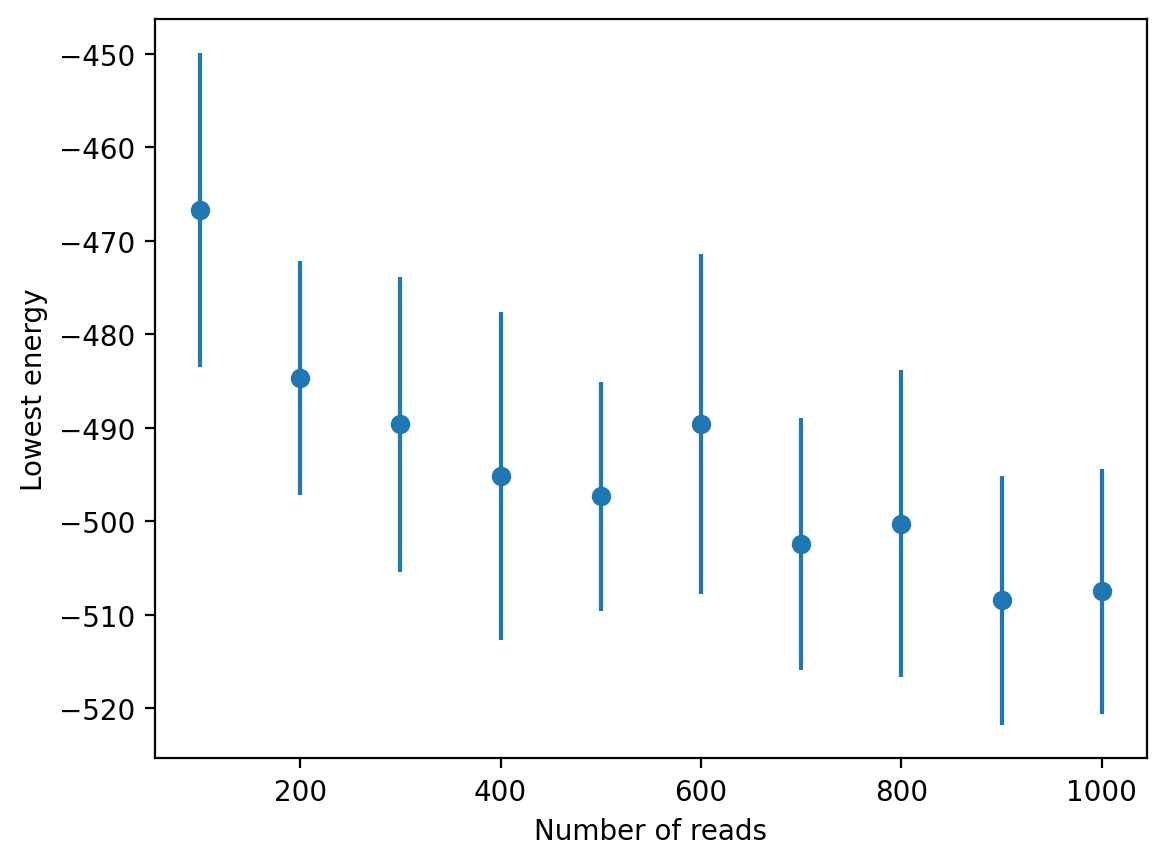

In [33]:
samples = pd.read_csv(path+"samples.csv")
means = []
stddev = []

for reads in no_reads:
    means.append(np.mean(samples.query(f"`Total reads` == {reads}")["Lowest energy"]))
    stddev.append(np.std(samples.query(f"`Total reads` == {reads}")["Lowest energy"]))

plt.errorbar(no_reads, means, yerr=stddev, fmt='o')
plt.xlabel("Number of reads")
plt.ylabel("Lowest energy")

<Figure size 640x480 with 0 Axes>

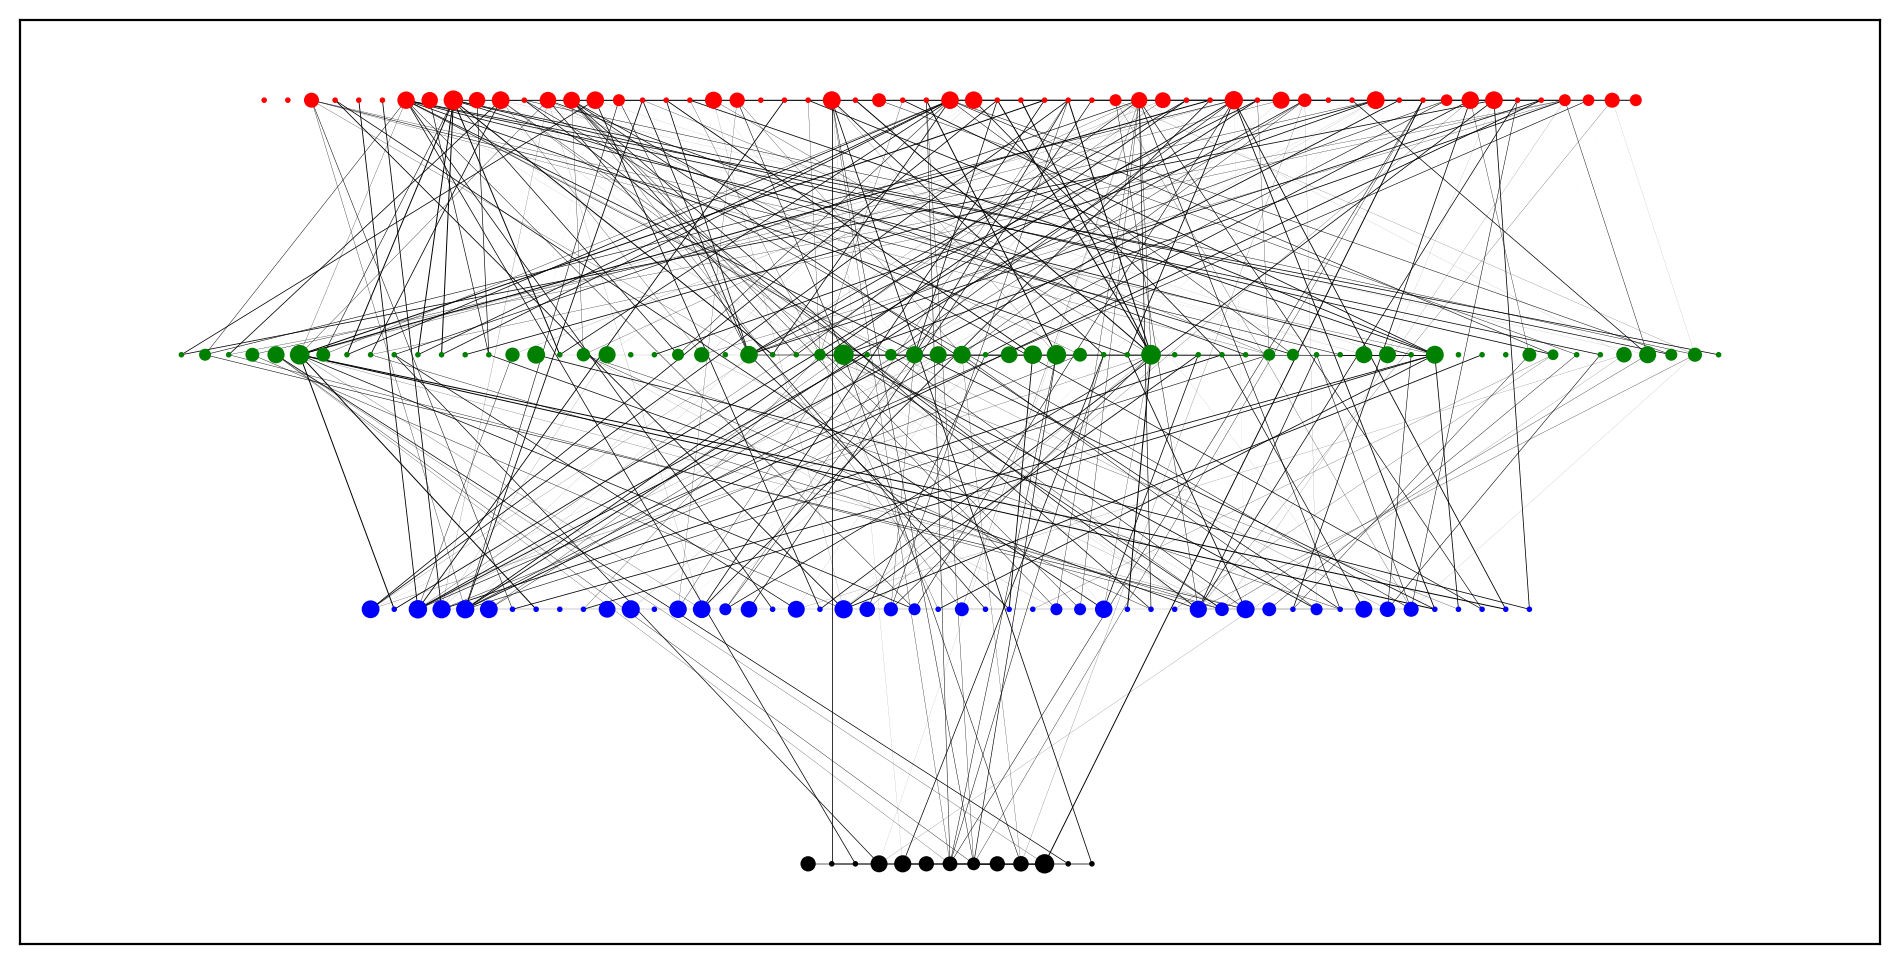

In [13]:
# Show results

sample = df["sample"][0]
plotSample(sample, G, [phrase for part in phrases for phrase in part])

#plotArrangement(sample, phrases, instruments)

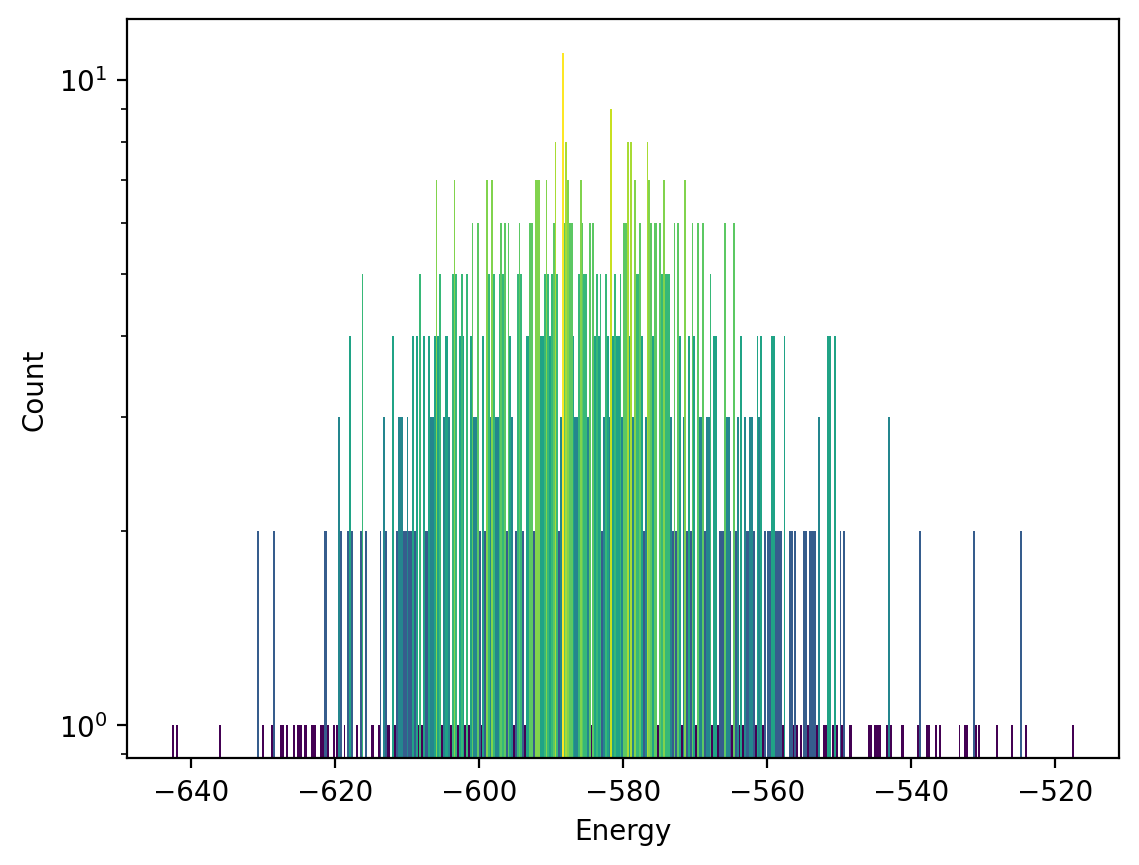

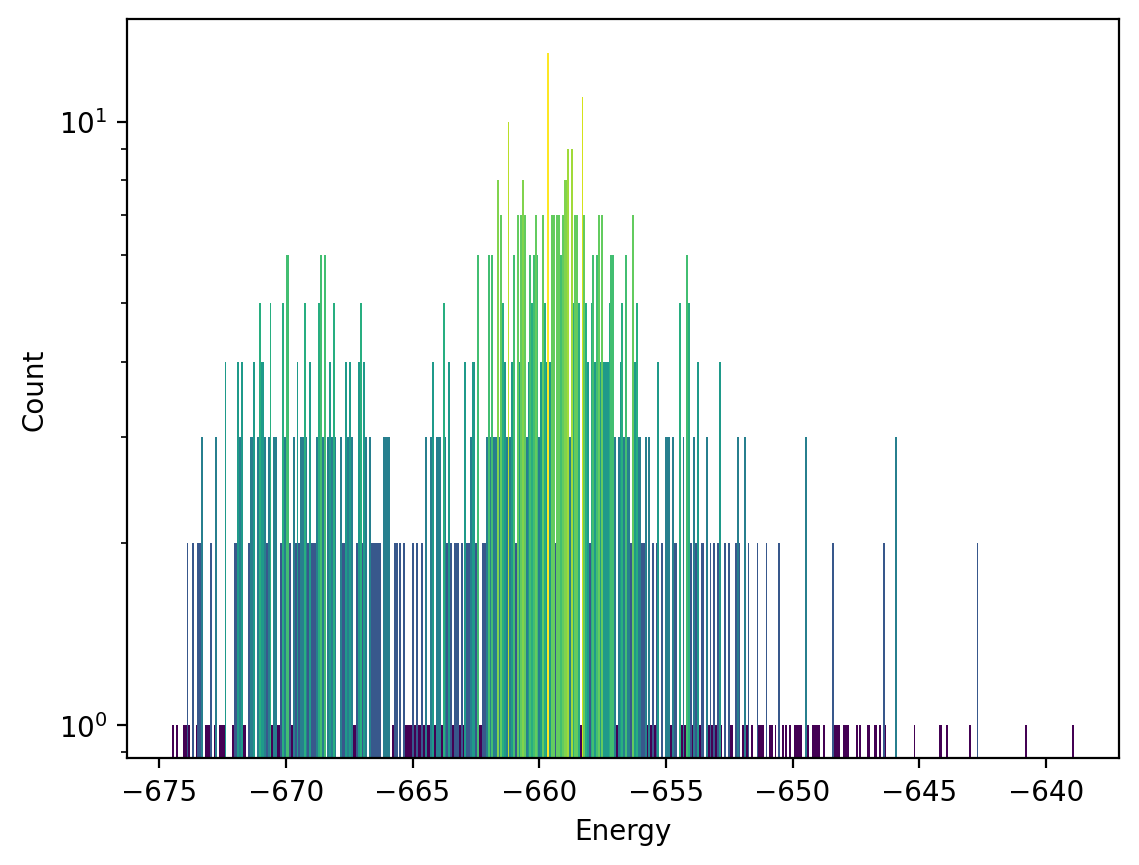

In [22]:
# Solve classically

sd = SteepestDescentSolver().sample(bqm, num_reads=1000).to_pandas_dataframe(True)
sa = SimulatedAnnealingSampler().sample(bqm, num_reads=1000).to_pandas_dataframe(True)

# Compare energies from different methods
# Just because it doesn't crash doesn't mean it passed

plotHistogram(sd)
plt.show()
plotHistogram(sa)
plt.show()

In [55]:
print(results.info.keys())
print(results.info["embedding_context"]["chain_strength"])
print(results.info["timing"]["qpu_anneal_time_per_sample"])
print(results.info["timing"]["qpu_access_time"])
print(results.info["timing"])
print(results.first.energy)
print(bqm.energy(results.first.sample))
print(results.first.sample)
print(results.first.chain_break_fraction)

dict_keys(['timing', 'problem_id', 'problem_label', 'embedding_context', 'warnings'])
6.280818928481725
20.0
285945.16
{'qpu_sampling_time': 270180.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 229.6, 'qpu_access_time': 285945.16, 'qpu_access_overhead_time': 5599.84, 'qpu_programming_time': 15765.16, 'qpu_delay_time_per_sample': 20.58, 'post_processing_overhead_time': 65.0, 'total_post_processing_time': 65.0}
-647.3579676840332
-647.3579676840332
{'Cello_10_blue': 0, 'Cello_10_green': 0, 'Cello_10_red': 1, 'Cello_11_blue': 1, 'Cello_11_green': 0, 'Cello_11_red': 0, 'Cello_12_blue': 1, 'Cello_12_green': 0, 'Cello_12_red': 0, 'Cello_13_blue': 0, 'Cello_13_green': 0, 'Cello_13_red': 1, 'Cello_14_blue': 0, 'Cello_14_green': 0, 'Cello_14_red': 0, 'Cello_15_blue': 0, 'Cello_15_green': 0, 'Cello_15_red': 0, 'Cello_16_blue': 0, 'Cello_16_green': 0, 'Cello_16_red': 0, 'Cello_17_blue': 0, 'Cello_17_green': 1, 'Cello_17_red': 0, 'Cello_18_blue': 0, 'Cello_18_green': 0, 'Ce

                                               sample      energy  \
10  {'Cello_10_blue': 1, 'Cello_10_green': 0, 'Cel... -250.266144   
6   {'Cello_10_blue': 0, 'Cello_10_green': 0, 'Cel... -236.716514   
33  {'Cello_10_blue': 0, 'Cello_10_green': 0, 'Cel... -222.488708   
62  {'Cello_10_blue': 0, 'Cello_10_green': 0, 'Cel... -209.039612   
57  {'Cello_10_blue': 0, 'Cello_10_green': 0, 'Cel... -206.638005   

    num_occurrences  chain_break_fraction  
10                1               0.00177  
6                 1               0.00177  
33                1               0.00177  
62                1               0.00177  
57                1               0.00177  
-166.558448757604


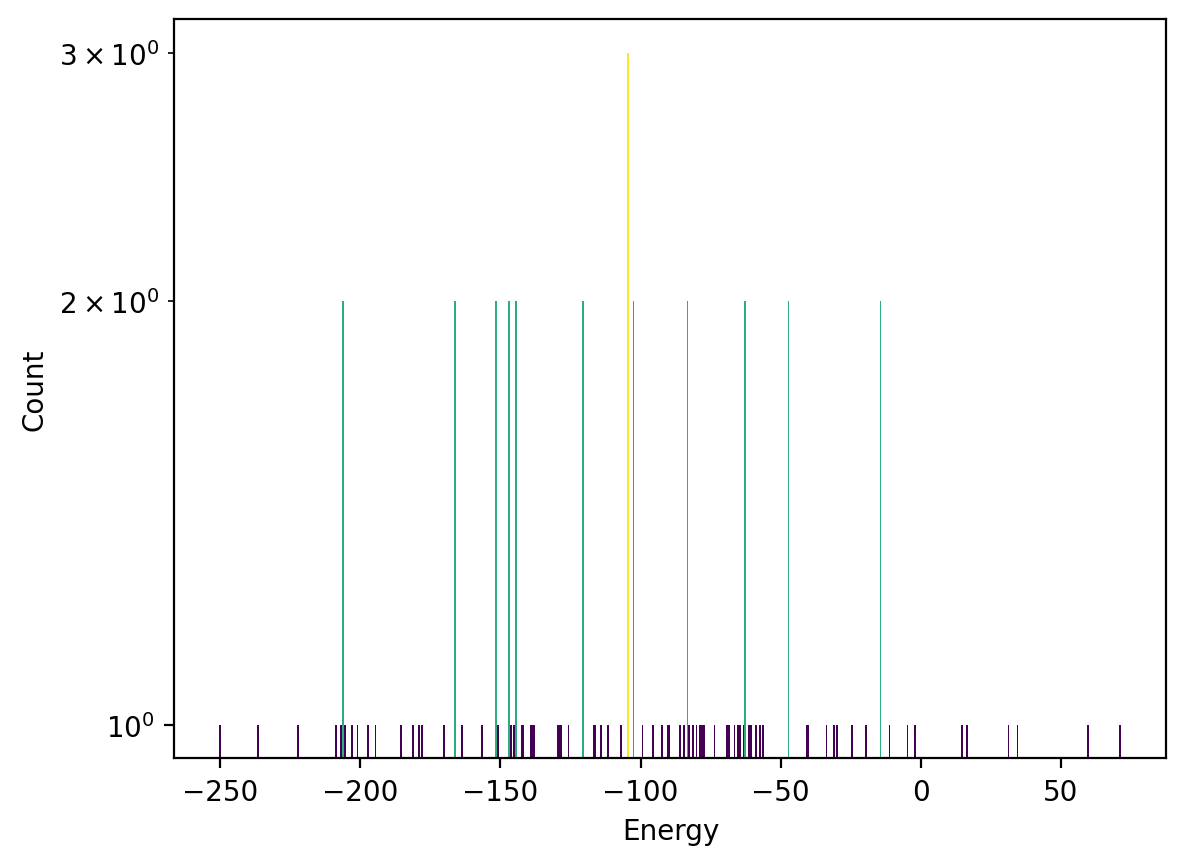

In [70]:
plotHistogram(df)
print(df.head())
print(bqm.energy(df["sample"][0]))

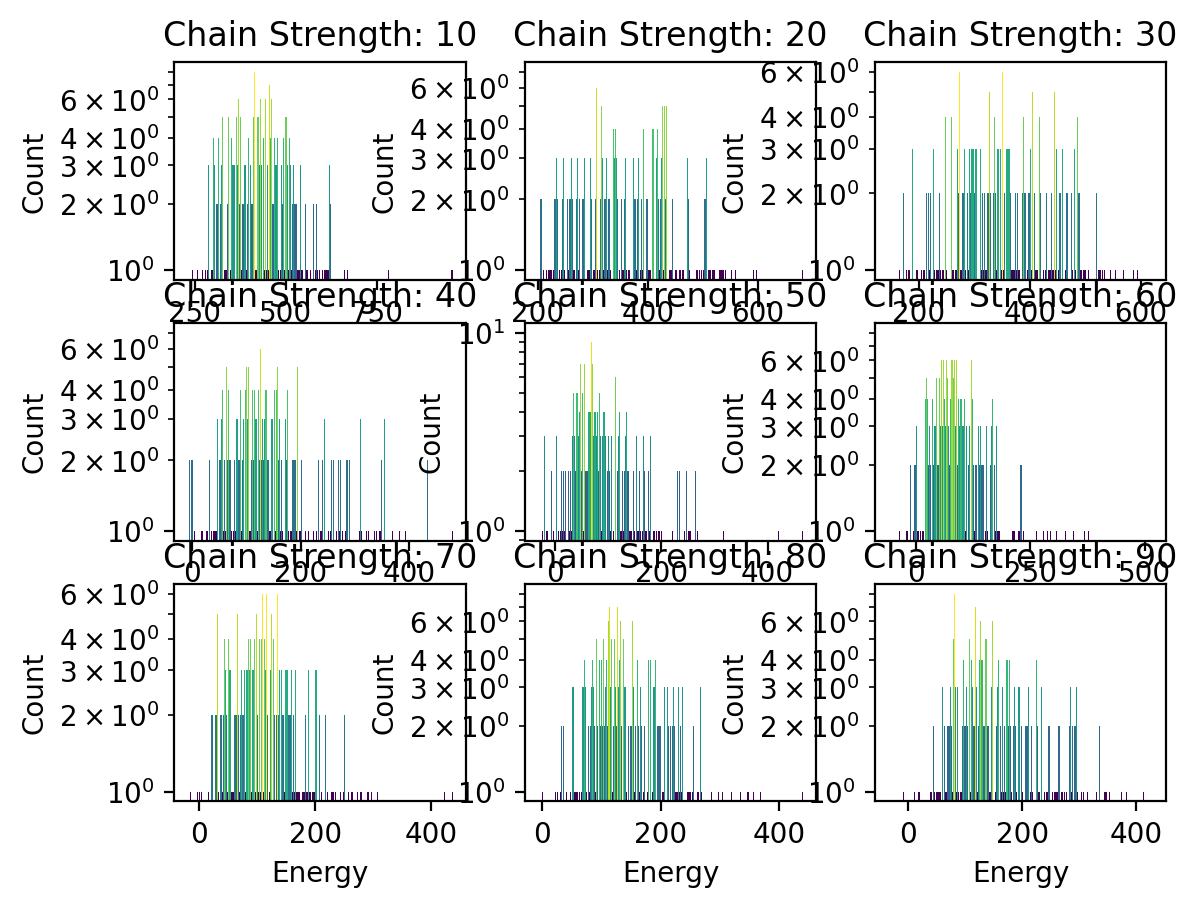

In [ ]:
chain_strengths = [10, 20, 30, 40, 50, 60, 70, 80, 90]
sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)
reads = 500
anneal_time = 400

for cs in chain_strengths:
    sampleset = sampler.sample(bqm, num_reads=reads, annealing_time=300, chain_strength=cs, label=f"Haydn_{reads}r_{anneal_time}us").to_pandas_dataframe(True)
    plt.subplot(3, 3, chain_strengths.index(cs)+1, sharex=True, sharey=True)
    plt.title(f"Chain Strength: {cs}")
    plotHistogram(sampleset)

plt.show()

<Figure size 640x480 with 0 Axes>

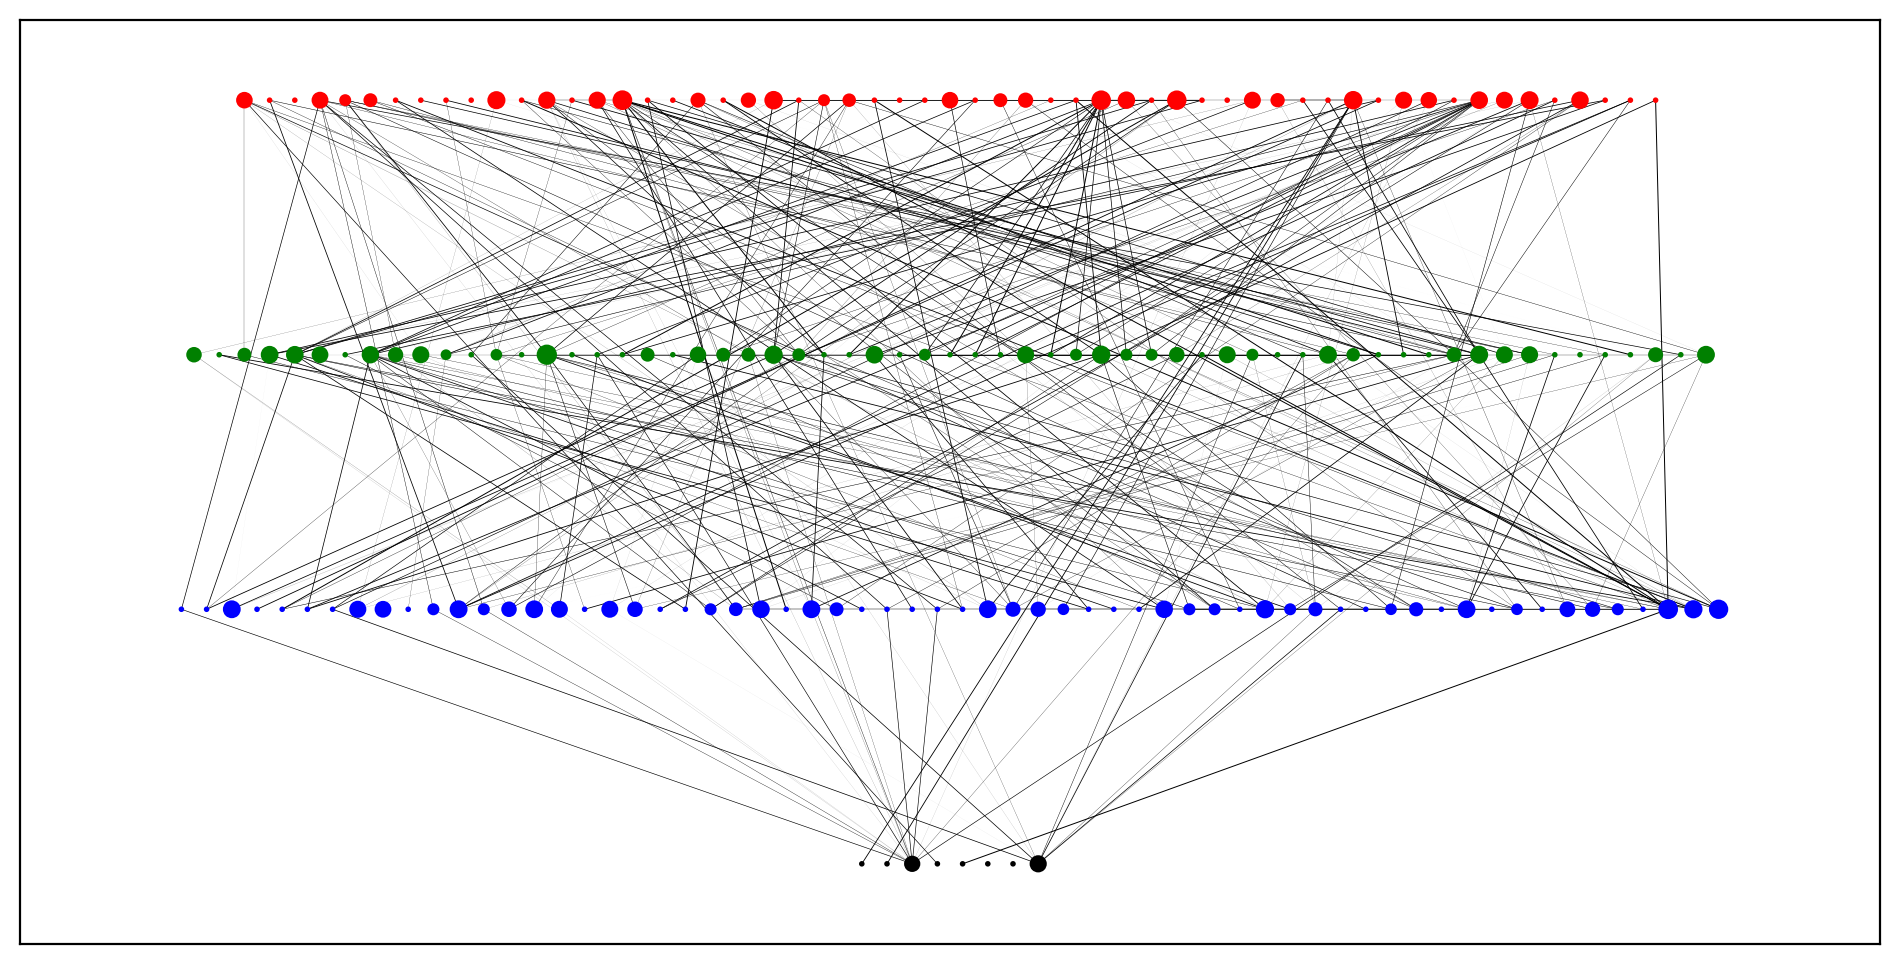

StreamException: The object you tried to add to the Stream, <class 'music21.instrument.Flute'>, is not a Music21Object.  Use an ElementWrapper object if this is what you intend.

In [ ]:

#arrangement.write(fmt="musicxml.pdf", fp="../Figures/poly.pdf", dpi=300)

# TODO: Bias selection of phrases to specific parts (e.g. by checking ambitus)
# TODO: Add meaningful edge weightings
# TODO: Find interesting constraints to add to BQM
# TODO: Are there more efficient ways to add constraints?